In [1]:
import numpy as np
import linac3
import matplotlib.pyplot as plt

In [36]:
start = "2018-11-23 16:30"
stop = "2018-11-26 04:30"

In [52]:
df = linac3.read_csv("../data/raw/Nov2018.csv").ffill()
sampling = 5
current = df.loc[(df.index >= start) & (df.index <= stop), linac3.SourceFeatures.BCT05_CURRENT].resample(f"{sampling}s").mean().ffill()
current = current[~np.isnan(current)] * 1000

current.size

Loading data from csv file '../data/raw/Nov2018.csv'


43201

(-20, 220)

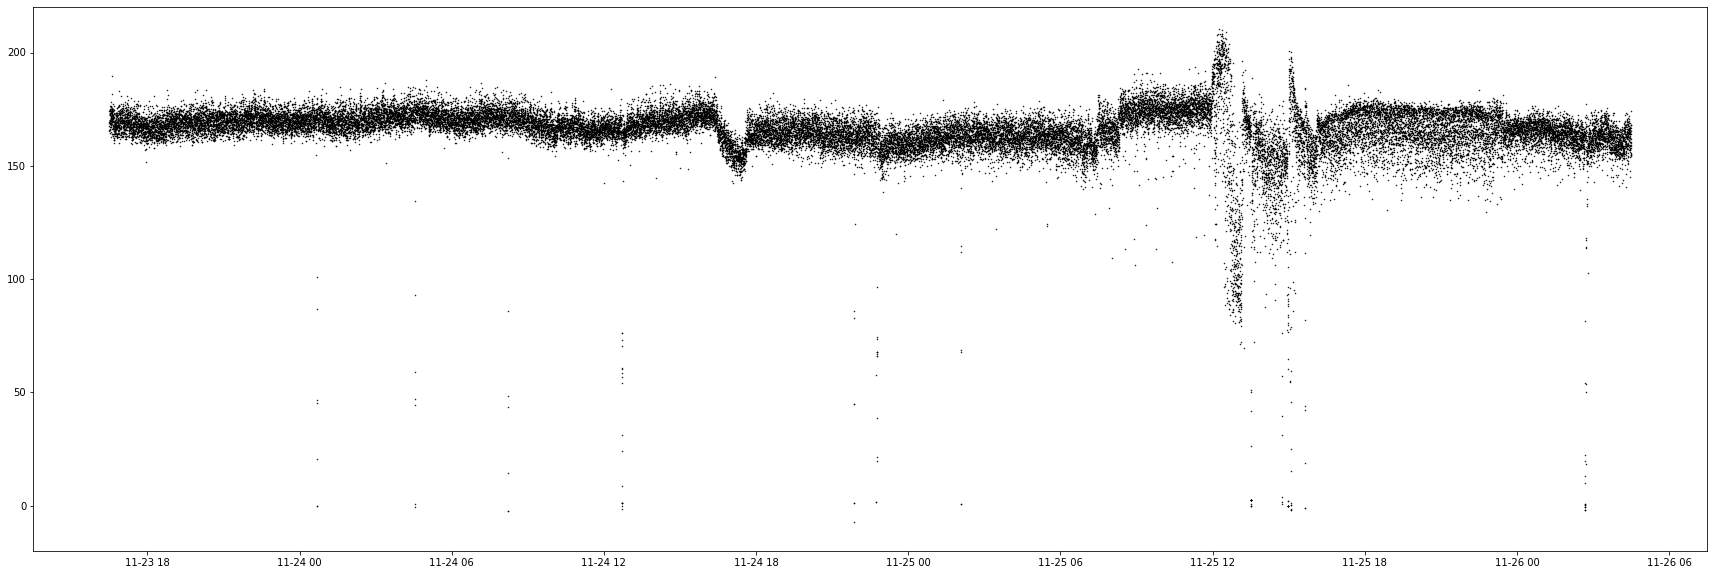

In [53]:
%matplotlib inline
fig, ax = plt.subplots(1,1,figsize=(30, 10))
ax.plot(current, color="black", ls="", ms=1, marker=".")
ax.set_ylim(-20, 220)

In [54]:
T = current.values

In [55]:
init_size = 60 * 60 // sampling # Take the first hour to estimate mean and variance of likelihood
mean_changepoint_distance = 3 * 60 * 60 // sampling # On average, one change point every six hours

In [56]:
from bocp_detector import BayesianDetector, ConstantHazard, StudentT


def create_detector(init_size, mean_changepoint_distance):
    hazard = ConstantHazard(mean_changepoint_distance) 

    init_mean, init_var = T[:init_size].mean(), T[:init_size].var()
    if init_var < 1e-7:
        init_var = 0.01

    kappa = 1#init_size
    alpha = 0.5#init_size * 0.5
    mu = init_mean
    beta = 0.5 * init_size * init_var

    observation_likelihood = StudentT(alpha, beta, kappa, mu)

    tail_threshold = 1e-4
    detector = BayesianDetector(hazard, observation_likelihood, tail_threshold)

    print(init_mean, np.sqrt(init_var))
    return detector

(-20, 230)

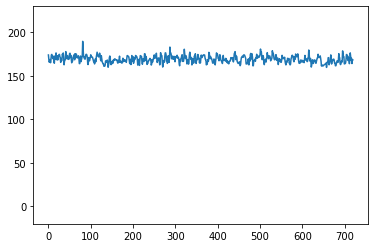

In [57]:
%matplotlib inline

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.plot(T[:init_size])
ax.set_ylim(-20, 230)

In [58]:
stepX, stepY = 1, 20

detector = create_detector(init_size, mean_changepoint_distance)

end = T.size
rec_probs = 2*mean_changepoint_distance
growth_matrix = np.zeros(((end - init_size) // stepX, rec_probs), dtype=float)
predictive_mean = np.zeros((end - init_size) // stepX, dtype=float)
predictive_std = np.zeros((end - init_size) // stepX, dtype=float)

cp = set([0])
for i, x in enumerate(T[init_size:end]):    
    if i % 1000 == 0:
        print(f"{i}/{end - init_size}")
    
    detector.update(x)
    new_cp = detector.detect(0.8, 0.1)
    if new_cp >= 0:
        #import pdb; pdb.set_trace()
        cp.add(i - new_cp)
        
    growth_probs = detector.get_growth_probabilities()
    
    l = min(growth_probs.size, rec_probs)
    if i % stepX == 0:
        growth_matrix[i // stepX, :l] = growth_probs[:l]
        predictive_mean[i // stepX] = detector.predictive_mean()
        predictive_std[i // stepX] = detector.predictive_std()
        
print(f"{end - init_size}/{end - init_size}")

169.29892 3.9794343
0/42481
1000/42481
2000/42481
3000/42481
4000/42481
5000/42481
6000/42481
7000/42481
8000/42481
9000/42481
10000/42481
11000/42481
12000/42481
13000/42481
14000/42481
15000/42481
16000/42481
17000/42481
18000/42481
19000/42481
20000/42481
21000/42481
22000/42481
23000/42481
24000/42481
25000/42481
26000/42481
27000/42481
28000/42481
29000/42481
30000/42481
31000/42481
32000/42481
33000/42481
34000/42481
35000/42481
36000/42481
37000/42481
38000/42481
39000/42481
40000/42481
41000/42481
42000/42481
42481/42481


In [59]:
f"Number of changepoints: {len(cp)}"

'Number of changepoints: 67'

In [63]:
%matplotlib widget

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(25, 15))

ax[0].plot(current.index[init_size::stepX], T[init_size::stepX])#, ls="", ms=1, marker=".", color="black")
ax[0].vlines([current.index[init_size+c] for c in cp], ymin=0, ymax=1, transform=ax[0].get_xaxis_transform(), color="red", ls="--")
ax[0].grid(True)
ax[0].set_ylabel("ITL.BCT05:Current [uA]", fontsize=20)
ax[0].tick_params(labelsize=13)

cmap = plt.get_cmap("Greys_r")
gmplot = growth_matrix.T.copy()
gmplot = np.log(gmplot, where=gmplot > 0, out=np.full(gmplot.shape, -np.inf))[::stepY, :]
im = ax[1].pcolormesh(current.index[init_size::stepX], np.arange(gmplot.shape[0]) * stepY, gmplot, cmap=cmap, vmin=-20, vmax=0)
ax[1].set_ylabel("Run length", fontsize=20)
ax[1].tick_params(labelsize=13)
#ax[1].plot(np.argmax(growth_matrix, axis=1) / stepY, ls="--", color="red")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [51]:
current[(current.index >="2018-11-25 23:45") & (current.index <= "2018-11-26 00:40")].std()

3.614908